In [28]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import lib_utils
from data import data_utils
from nets import utils
from nets import mobilenet_v2 as mobilenet
from nets import mobilenet_v2_140 as mobilenet_140

In [29]:
dataset_type = 'orchids52_v1_tf'
model_name = 'mobilenet_v2_140'
batch_size = 32
learning_rate = 0.001
optimizer = 'rmsprop'
exp_decay = False
train_step = 1
num_classes = 52
training = True

In [30]:
workspace_path = os.environ["WORKSPACE"] if "WORKSPACE" in os.environ else "/Volumes/Data/tmp"
data_path = os.environ["DATA_DIR"] if "DATA_DIR" in os.environ else "/Users/watcharinsarachai/Documents/_datasets/"
data_dir = os.path.join(data_path, "orchids52_data")

In [31]:
print (data_dir)

/Volumes/Data/_dataset/_orchids_dataset/orchids52_data


In [32]:
load_dataset = data_utils.dataset_mapping[dataset_type]
create_model = utils.nets_mapping[model_name]
checkpoint_path = os.path.join(workspace_path, "orchids-models", "orchids2019", model_name)

In [33]:
print (checkpoint_path)

/Volumes/Data/tmp/orchids-models/orchids2019/mobilenet_v2_140


In [34]:
if not tf.io.gfile.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

In [35]:
train_ds = load_dataset(split="train", batch_size=batch_size, root_path=data_dir)
test_ds = load_dataset(split="test", batch_size=batch_size, root_path=data_dir)

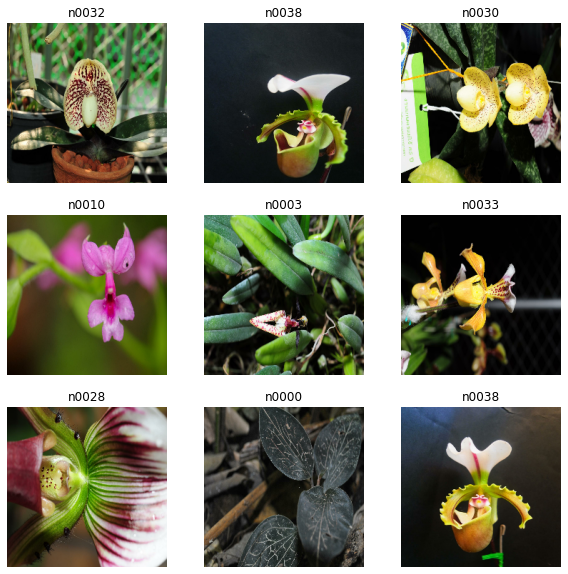

In [36]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        label = tf.argmax(labels[i], axis=0)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.classes[label][0])
        plt.axis("off")

In [37]:
training_step = utils.TRAIN_TEMPLATE.format(step=train_step)

In [38]:
learning_rate = lib_utils.config_learning_rate(learning_rate=learning_rate, exp_decay=exp_decay, training_step=training_step)
learning_rate

0.001

In [51]:
optimizer = lib_utils.config_optimizer(optimizer, learning_rate=learning_rate, training_step=training_step)
optimizer

In [40]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [41]:
base_model = mobilenet.create_mobilenet_v2(input_shape=mobilenet.IMG_SHAPE_224, alpha=1.4, include_top=False, weights="imagenet", sub_name="01")
base_model.trainable = False

In [42]:
base_model.summary()

Model: "mobilenetv2_01_1.40_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mobilenetv2_01_1.40_224_input ( [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
mobilenetv2_01_1.40_224_Conv1_p (None, 225, 225, 3)  0           mobilenetv2_01_1.40_224_input[0][
__________________________________________________________________________________________________
mobilenetv2_01_1.40_224_Conv1 ( (None, 112, 112, 48) 1296        mobilenetv2_01_1.40_224_Conv1_pad
__________________________________________________________________________________________________
mobilenetv2_01_1.40_224_bn_Conv (None, 112, 112, 48) 192         mobilenetv2_01_1.40_224_Conv1[0][
____________________________________________________________________________

In [43]:
preprocess_layer = mobilenet_140.PreprocessLayer()
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
inputs = tf.keras.Input(shape=mobilenet.IMG_SHAPE_224)
prediction_layer = mobilenet_140.PredictionLayer(num_classes=num_classes, shape=[1, 7, 7], activation="softmax")

In [44]:
processed_inputs = preprocess_layer(inputs, training=training)
rescale_inputs = rescale(processed_inputs)
mobilenet_logits = base_model(rescale_inputs, training=training)
outputs = prediction_layer(mobilenet_logits, training=training)

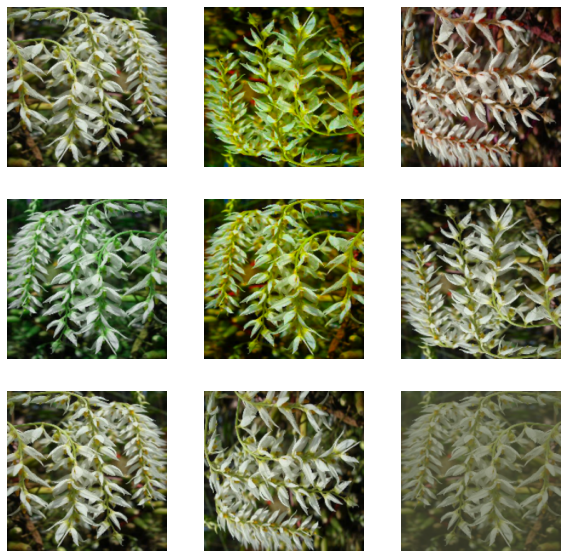

In [45]:
_model = tf.keras.Model(inputs, processed_inputs)
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = _model(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image.numpy().astype("uint8")[0])
        plt.axis('off')

In [46]:
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
preprocess_layer_1 (Preproce (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_01_1.40_224 (Fun (None, 7, 7, 1792)        4363712   
_________________________________________________________________
prediction_layer_1 (Predicti (None, 52)                93236     
Total params: 4,456,948
Trainable params: 93,236
Non-trainable params: 4,363,712
_________________________________________________________________


In [47]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [48]:
loss0, accuracy0 = model.evaluate(test_ds)

24/24 [==============================] - 10s 345ms/step - loss: 3.9912 - accuracy: 0.0237


In [49]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.99
initial accuracy: 0.03


In [50]:
history = model.fit(train_ds, epochs=100)

Epoch 1/100
89/89 [==============================] - 33s 345ms/step - loss: 3.9920 - accuracy: 0.0216
Epoch 2/100
89/89 [==============================] - 16s 182ms/step - loss: 3.9918 - accuracy: 0.0188
Epoch 3/100
89/89 [==============================] - 16s 183ms/step - loss: 3.9917 - accuracy: 0.0199
Epoch 4/100
89/89 [==============================] - 16s 183ms/step - loss: 3.9912 - accuracy: 0.0213
Epoch 5/100
89/89 [==============================] - 16s 182ms/step - loss: 3.9917 - accuracy: 0.0220
Epoch 6/100
89/89 [==============================] - 16s 182ms/step - loss: 3.9908 - accuracy: 0.0223
Epoch 7/100
89/89 [==============================] - 16s 182ms/step - loss: 3.9910 - accuracy: 0.0216
Epoch 8/100
89/89 [==============================] - 16s 182ms/step - loss: 3.9903 - accuracy: 0.0259
Epoch 9/100
89/89 [==============================] - 16s 182ms/step - loss: 3.9897 - accuracy: 0.0223
Epoch 10/100
89/89 [==============================] - 16s 182ms/step - loss: 3.989

KeyboardInterrupt: 

In [ ]:
loss0, accuracy0 = model.evaluate(test_ds)

In [ ]:
model.save(checkpoint_path)

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()